In [9]:
import numpy as np
import os
import cv2
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, Conv2DTranspose, Input, \
    concatenate, Activation
from tensorflow.keras.applications import ResNet50, Xception
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

mixed_precision.set_global_policy('mixed_float16')

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Define class labels
CLASS_NAMES = {
    0: "epidural",
    1: "intraparenchymal",
    2: "intraventricular",
    3: "normal",        # Changed from "multi" to "normal"
    4: "subarachnoid",  # Changed from "normal" to "subarachnoid"
    5: "subdural"       # Changed from "subarachnoid" to "subdural"
}


def load_and_stack_as_rgb(brain_bone_path, brain_path, subdural_path):
    """
    Reads three grayscale images and combines them into an RGB image.

    - brain_bone_window → Red channel
    - brain_window → Green channel
    - subdural_window → Blue channel

    Returns a (H, W, 3) RGB image.
    """
    # Load grayscale images
    brain_bone = cv2.imread(brain_bone_path, cv2.IMREAD_GRAYSCALE)
    brain = cv2.imread(brain_path, cv2.IMREAD_GRAYSCALE)
    subdural = cv2.imread(subdural_path, cv2.IMREAD_GRAYSCALE)

    # Ensure all images are the same shape
    if not (brain_bone.shape == brain.shape == subdural.shape):
        raise ValueError("Input images do not have same size")

    if not (brain_bone.shape == (512, 512)):
        print("\nbrain_bone.shape = ", brain_bone.shape, "\tbrain.shape = ", brain.shape, "\tsubdural.shape = ",
              subdural.shape)
        print("Path = ", brain_bone_path)

    # Normalize pixel values to [0,1] (optional, but recommended)
    brain_bone = brain_bone / 255.0
    brain = brain / 255.0
    subdural = subdural / 255.0

    # Stack images into an RGB format
    rgb_image = np.stack([brain_bone, brain, subdural], axis=-1)

    # Convert back to 0-255 and uint8 for visualization/saving
    # rgb_image = (rgb_image * 255).astype(np.uint8)

    return rgb_image


def find_matching_image_paths(bone_folder, brain_folder, subdural_folder):
    """
    Walks through the subfolders and finds images with the same filename across all three directories.

    Returns a list of tuples containing matching image paths from each folder.
    """
    # Get the list of all image filenames in each directory
    bone_images = set(os.listdir(bone_folder))
    brain_images = set(os.listdir(brain_folder))
    subdural_images = set(os.listdir(subdural_folder))

    # Find common filenames across all three folders
    common_files = bone_images.intersection(brain_images).intersection(subdural_images)

    # Create a list of tuples with paths to the matching images
    matching_image_paths = []
    for filename in common_files:
        bone_path = os.path.join(bone_folder, filename)
        brain_path = os.path.join(brain_folder, filename)
        subdural_path = os.path.join(subdural_folder, filename)
        matching_image_paths.append((bone_path, brain_path, subdural_path))

    return matching_image_paths


def load_image(file_path):
    """
    Load an image file, decode it, and convert to float32.
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1)  # or decode_jpeg depending on your files
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def load_and_preprocess_image(file_path, target_size=(256, 256)):
    """
    Load an image file, decode it, resize it, and convert to float32.
    """
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=1)  # or decode_jpeg

    # Resize to smaller dimensions to save memory
    img = tf.image.resize(img, target_size)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_path(bone_path, brain_path, subdural_path, label, target_size=(256, 256)):
    # Load and resize the images
    bone_img = load_and_preprocess_image(bone_path, target_size)
    brain_img = load_and_preprocess_image(brain_path, target_size)
    subdural_img = load_and_preprocess_image(subdural_path, target_size)

    # Apply contrast enhancement
    bone_img = tf.image.adjust_contrast(bone_img, 1.5)
    brain_img = tf.image.adjust_contrast(brain_img, 1.5)
    subdural_img = tf.image.adjust_contrast(subdural_img, 1.5)

    # Ensure normalization is consistent
    bone_img = tf.clip_by_value(bone_img, 0.0, 1.0)
    brain_img = tf.clip_by_value(brain_img, 0.0, 1.0)
    subdural_img = tf.clip_by_value(subdural_img, 0.0, 1.0)

    # Stack the images
    image = tf.concat([bone_img, brain_img, subdural_img], axis=-1)

    return image, label


def prepare_path_and_label_lists():
    """
    Prepare lists of file paths and corresponding labels.
    """
    # List of (folder_prefixes, class_label)
    class_info = [
        ("epidural", 0),
        ("intraparenchymal", 1),
        ("intraventricular", 2),
        ("normal", 3),           # Changed from 4 to 3
        ("subarachnoid", 4),     # Changed from 5 to 4
        ("subdural", 5)          # Changed from 6 to 5
        # "multi" class removed entirely
    ]

    all_bone_paths = []
    all_brain_paths = []
    all_subdural_paths = []
    all_labels = []

    # Use a smaller number for each class to reduce memory usage
    min_num_type = 1694  # Reduced from 1000

    for prefix, label in class_info:
        bone_folder = f'renders/{prefix}/brain_bone_window'
        brain_folder = f'renders/{prefix}/brain_window'
        subdural_folder = f'renders/{prefix}/subdural_window'

        matching_paths = find_matching_image_paths(bone_folder, brain_folder, subdural_folder)
        selected_paths = matching_paths[:min_num_type]

        for bone_path, brain_path, subdural_path in selected_paths:
            all_bone_paths.append(bone_path)
            all_brain_paths.append(brain_path)
            all_subdural_paths.append(subdural_path)
            all_labels.append(label)

    return all_bone_paths, all_brain_paths, all_subdural_paths, all_labels


def configure_for_performance(ds, batch_size=8, buffer_size=1000, shuffle=True):
    """
    Configure dataset for performance with reduced batch size.
    """
    # Shuffle if needed
    if shuffle:
        ds = ds.shuffle(buffer_size=buffer_size)

    # Use smaller batch size
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds


def create_hemorrhage_datasets(batch_size=8, validation_split=0.2, test_split=0.1,
                               target_size=(256, 256), seed=42):
    """
    Create train, validation, and test datasets with memory optimizations.
    """
    # Get file paths and labels
    bone_paths, brain_paths, subdural_paths, labels = prepare_path_and_label_lists()

    # Convert to tensors
    bone_paths = tf.convert_to_tensor(bone_paths)
    brain_paths = tf.convert_to_tensor(brain_paths)
    subdural_paths = tf.convert_to_tensor(subdural_paths)
    labels = tf.convert_to_tensor(labels)

    # Calculate dataset sizes
    dataset_size = len(labels)
    test_size = int(test_split * dataset_size)
    val_size = int(validation_split * dataset_size)
    train_size = dataset_size - val_size - test_size

    # Create full dataset
    full_dataset = tf.data.Dataset.from_tensor_slices((bone_paths, brain_paths, subdural_paths, labels))

    # Shuffle
    full_dataset = full_dataset.shuffle(buffer_size=dataset_size, seed=seed)

    # Split into train, validation, and test
    train_ds = full_dataset.take(train_size)
    remaining_ds = full_dataset.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    # Map to process the data with resizing
    train_ds = train_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    test_ds = test_ds.map(
        lambda b, br, s, l: process_path(b, br, s, l, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Configure datasets for performance with smaller batch size
    train_ds = configure_for_performance(train_ds, batch_size=batch_size, shuffle=True)
    val_ds = configure_for_performance(val_ds, batch_size=batch_size, shuffle=False)
    test_ds = configure_for_performance(test_ds, batch_size=batch_size, shuffle=False)

    return train_ds, val_ds, test_ds


# Function to create a model (modify according to your needs)
def create_model(input_shape=(256, 256, 3), num_classes=7):
    """
    Create a CNN model for hemorrhage classification.
    """
    # You can use your own model architecture here
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )

    # Freeze the base model
    base_model.trainable = False

    # Add classification head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Create a lighter model
def create_lightweight_model(input_shape=(256, 256, 3), num_classes=7):
    """
    Create a more memory-efficient CNN model for hemorrhage classification.
    """
    inputs = tf.keras.Input(shape=input_shape)

    # Use MobileNetV2 instead of ResNet50 (much lighter)
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        input_shape=input_shape
    )

    # Freeze the base model
    base_model.trainable = False

    # Add classification head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)  # Smaller dense layer
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile with mixed precision
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    if tf.config.list_physical_devices('GPU'):
        # Use mixed precision if GPU is available
        optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Alternative: Custom lightweight CNN
def create_custom_cnn(input_shape=(256, 256, 3), num_classes=7):
    """
    Create a custom lightweight CNN that uses less memory than pre-trained models.
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),

        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),

        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),

        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),

        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def create_improved_cnn(input_shape=(256, 256, 3), num_classes=7):
    # Create a more specialized model for medical imaging
    inputs = tf.keras.Input(shape=input_shape)

    # First block - focus on edge detection
    x = tf.keras.layers.Conv2D(32, (5, 5), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Second block - more features
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Third block - deeper features
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Feature extraction
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Classification head
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def build_unet_classifier_with_pretrained_encoder(input_shape=(256, 256, 3), num_classes=6, encoder_type='resnet50',
                                                  pretrained=True):
    """
    Build U-Net with a pre-trained encoder backbone for classification tasks

    Args:
        input_shape: Input shape of the images
        num_classes: Number of classes for classification
        encoder_type: 'resnet50' or 'xception'
        pretrained: Whether to use pre-trained weights (True) or random initialization (False)

    Returns:
        U-Net model adapted for classification tasks
    """
    inputs = Input(shape=input_shape)

    # Select pre-trained encoder
    if encoder_type == 'resnet50':
        weights = 'imagenet' if pretrained else None
        base_model = ResNet50(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers
        s1 = base_model.get_layer('conv1_relu').output  # 256x256
        s2 = base_model.get_layer('conv2_block3_out').output  # 128x128
        s3 = base_model.get_layer('conv3_block4_out').output  # 64x64
        s4 = base_model.get_layer('conv4_block6_out').output  # 32x32

        # Bridge
        bridge = base_model.get_layer('conv5_block3_out').output  # 16x16

    elif encoder_type == 'xception':
        weights = 'imagenet' if pretrained else None
        base_model = Xception(include_top=False, weights=weights, input_tensor=inputs)

        # Extract skip connection layers
        s1 = base_model.get_layer('block2_sepconv2_bn').output  # 128x128
        s2 = base_model.get_layer('block3_sepconv2_bn').output  # 64x64
        s3 = base_model.get_layer('block4_sepconv2_bn').output  # 32x32
        s4 = base_model.get_layer('block13_sepconv2_bn').output  # 16x16

        # Bridge
        bridge = base_model.get_layer('block14_sepconv2_bn').output  # 16x16
    else:
        raise ValueError(f"Unsupported encoder type: {encoder_type}. Choose 'resnet50' or 'xception'")

    # Decoder path - but with fewer upsampling blocks for classification
    # First upsampling block
    u1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(bridge)
    u1 = concatenate([u1, s4])
    u1 = Conv2D(256, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Dropout(0.3)(u1)

    # Second upsampling block
    u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, s3])
    u2 = Conv2D(256, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Dropout(0.3)(u2)

    # Global average pooling for classification
    gap = GlobalAveragePooling2D()(u2)

    # Classification head
    x = Dense(256, activation='relu')(gap)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


def set_encoder_trainable(model, trainable=False):
    """
    Set trainable property of the encoder layers

    Args:
        model: The U-Net model with pre-trained encoder
        trainable: Whether to make encoder layers trainable (True) or frozen (False)
    """
    # Find the pre-trained backbone layers
    for layer in model.layers:
        if isinstance(layer, tf.keras.models.Model):  # This is the base model
            for base_layer in layer.layers:
                base_layer.trainable = trainable

    return model

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D

# Create datasets (using your existing function)
train_ds, val_ds, test_ds = create_hemorrhage_datasets(
    batch_size=8,
    validation_split=0.2,
    test_split=0.1,
    target_size=(256, 256)
)

# Create the U-Net classifier model
unet_classifier = build_unet_classifier_with_pretrained_encoder(
    input_shape=(256, 256, 3),
    num_classes=7,
    encoder_type='resnet50',
    pretrained=True
)

# Initially, freeze the encoder weights
unet_classifier = set_encoder_trainable(unet_classifier, trainable=False)

# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'classifier_6_class_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model with frozen encoder
history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

# Fine-tune the model by unfreezing the encoder
unet_classifier = set_encoder_trainable(unet_classifier, trainable=True)

# Lower learning rate for fine-tuning
unet_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with unfrozen encoder
fine_tune_history = unet_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2268 - loss: 1.8093

890/890 ━━━━━━━━━━━━━━━━━━━━ 2658s 3s/step - accuracy: 0.2268 - loss: 1.8093 - val_accuracy: 0.1757 - val_loss: 4.6564
Epoch 2/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2750 - loss: 1.7034

890/890 ━━━━━━━━━━━━━━━━━━━━ 2552s 3s/step - accuracy: 0.2750 - loss: 1.7034 - val_accuracy: 0.2785 - val_loss: 1.7119
Epoch 3/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 2534s 3s/step - accuracy: 0.2878 - loss: 1.6843 - val_accuracy: 0.1590 - val_loss: 2.8293
Epoch 4/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2803 - loss: 1.6782

890/890 ━━━━━━━━━━━━━━━━━━━━ 2537s 3s/step - accuracy: 0.2803 - loss: 1.6781 - val_accuracy: 0.2943 - val_loss: 1.6905
Epoch 5/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 2532s 3s/step - accuracy: 0.2877 - loss: 1.6722 - val_accuracy: 0.2343 - val_loss: 1.7324
Epoch 6/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 2532s 3s/step - accuracy: 0.2983 - loss: 1.6570 - val_accuracy: 0.2761 - val_loss: 1.7003
Epoch 7/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 2526s 3s/step - accuracy: 0.3002 - loss: 1.6467 - val_accuracy: 0.2106 - val_loss: 1.9982
Epoch 8/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 2522s 3s/step - accuracy: 0.3076 - loss: 1.6493 - val_accuracy: 0.2416 - val_loss: 1.9311
Epoch 9/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3186 - loss: 1.6364

890/890 ━━━━━━━━━━━━━━━━━━━━ 2517s 3s/step - accuracy: 0.3186 - loss: 1.6364 - val_accuracy: 0.3066 - val_loss: 1.6473
Epoch 10/10
890/890 ━━━━━━━━━━━━━━━━━━━━ 2529s 3s/step - accuracy: 0.3172 - loss: 1.6232 - val_accuracy: 0.3007 - val_loss: 1.6322
Epoch 1/5
890/890 ━━━━━━━━━━━━━━━━━━━━ 2611s 3s/step - accuracy: 0.3130 - loss: 1.6158 - val_accuracy: 0.3046 - val_loss: 1.6555
Epoch 2/5
890/890 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3302 - loss: 1.6082

890/890 ━━━━━━━━━━━━━━━━━━━━ 2582s 3s/step - accuracy: 0.3302 - loss: 1.6082 - val_accuracy: 0.3361 - val_loss: 1.5953
Epoch 3/5
890/890 ━━━━━━━━━━━━━━━━━━━━ 2586s 3s/step - accuracy: 0.3485 - loss: 1.5938 - val_accuracy: 0.3332 - val_loss: 1.5848
Epoch 4/5
890/890 ━━━━━━━━━━━━━━━━━━━━ 3326s 4s/step - accuracy: 0.3427 - loss: 1.5908 - val_accuracy: 0.2687 - val_loss: 1.6416
Epoch 5/5
890/890 ━━━━━━━━━━━━━━━━━━━━ 3697s 4s/step - accuracy: 0.3339 - loss: 1.5904 - val_accuracy: 0.3292 - val_loss: 1.5838


In [11]:
# Evaluate the model on test data
unet_classifier.load_weights('classifier_6_class_best.h5')
test_loss, test_accuracy = unet_classifier.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.4f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 113s 885ms/step - accuracy: 0.3107 - loss: 1.6390
Test accuracy: 0.3140


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step


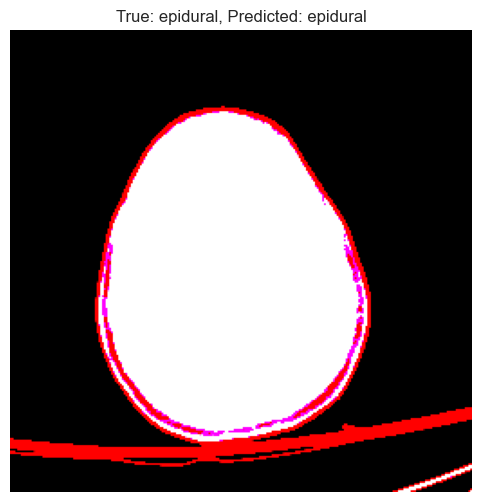

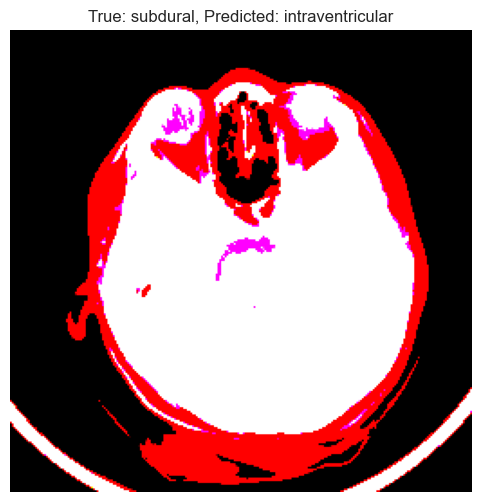

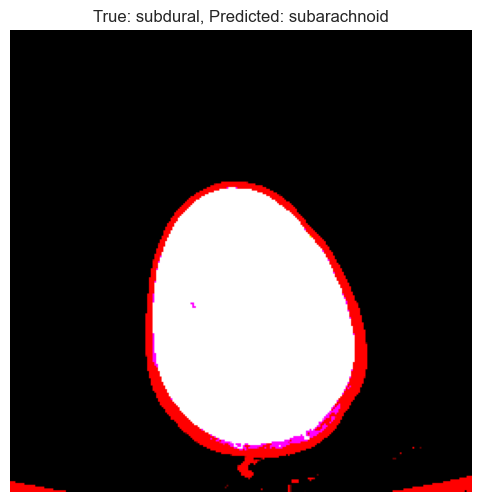

In [17]:
# Make predictions
for images, labels in test_ds.take(1):
    predictions = unet_classifier.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    # Display sample images with true and predicted labels
    for i in range(min(3, len(images))):
        plt.figure(figsize=(8, 6))
        plt.imshow(images[i])
        true_class = CLASS_NAMES[labels[i].numpy()]
        pred_class = CLASS_NAMES[predicted_classes[i]]
        plt.title(f"True: {true_class}, Predicted: {pred_class}")
        plt.axis('off')
        plt.show()

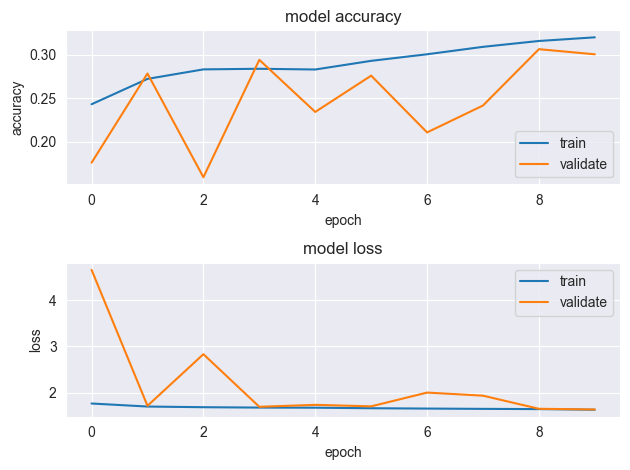

In [13]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')

plt.tight_layout()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

def evaluate_and_visualize_confusion_matrix(model, test_dataset, class_names, title="Confusion Matrix"):
    """
    Evaluate a model on test data and visualize the confusion matrix

    Args:
        model: Trained Keras model
        test_dataset: tf.data.Dataset containing test data
        class_names: Dictionary mapping class indices to class names
        title: Title for the confusion matrix plot
    """
    # Get predictions and true labels
    y_pred_list = []
    y_true_list = []

    # Get predictions in batches
    for x_batch, y_batch in test_dataset:
        y_pred = model.predict(x_batch)
        y_pred_classes = np.argmax(y_pred, axis=1)

        y_pred_list.extend(y_pred_classes)
        y_true_list.extend(y_batch.numpy())

    y_pred_array = np.array(y_pred_list)
    y_true_array = np.array(y_true_list)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_array, y_pred_array)

    # Create class labels list from the dictionary
    class_labels = [class_names[i] for i in range(len(class_names))]

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(y_true_array, y_pred_array,
                                target_names=class_labels))

    # Calculate overall accuracy
    accuracy = np.sum(y_pred_array == y_true_array) / len(y_true_array)
    print(f"Overall Accuracy: {accuracy:.4f}")

    return cm

In [ ]:
# Example usage for 6-class model
# First, load your trained 6-class model
model_6class = tf.keras.models.load_model('path_to_your_6class_model.h5')

# Create test dataset (assuming your data preparation functions have been updated to exclude "multi" class)
test_ds_6class = create_hemorrhage_datasets(batch_size=batch_size,
                                           validation_split=0.2,
                                           test_split=0.1,
                                           target_size=input_shape[:2])[2]  # Get test dataset only

# Evaluate and visualize
cm_6class = evaluate_and_visualize_confusion_matrix(
    model_6class,
    test_ds_6class,
    CLASS_NAMES,
    title="6-Class Hemorrhage Classification Confusion Matrix"
)
